In [41]:
import mysql.connector as mariadb
import pandas as pd
import pandas.io.sql as psql
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

load_dotenv()

import pdb

### Connect to Database

In [165]:
db=mariadb.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASS"),
    db=os.getenv("DB_NAME"))
query = "select title, date from {}".format(os.getenv("DB_TABLE_NAME"))
forum_titles_frame = psql.read_sql(query, con=db)
db.close()

### Data content and shape

In [166]:
forum_titles_frame.head()

,title,date
0,libro inglés 3 - american english file 2b (sec...,2020-06-05
1,arriendo habitación n club hípico 641 a dos cu...,2020-06-02
2,búsqueda de desarrollador market place - progr...,2020-06-05
3,arriendo pieza metro alcántara,2020-05-31
4,respecto a estudiar al 100% en medio de una pa...,2020-06-02


In [167]:
# pdb.set_trace()
forum_titles_frame.shape

(91986, 2)

In [168]:
forum_titles_frame.index

RangeIndex(start=0, stop=91986, step=1)

### Threads count per year

In [169]:
forum_titles_frame[['date']] = forum_titles_frame[['date']].apply(lambda datestamp: datestamp.dt.year)
forum_titles_frame.groupby(['date']).count().loc[2011]

title    15503
Name: 2011, dtype: int64

In [170]:
count_titles = forum_titles_frame.groupby(['date']).count()
count_titles.index

Int64Index([2002, 2003, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
            2015, 2016, 2017, 2018, 2019, 2020],
           dtype='int64', name='date')

In [49]:
selected_years_mask = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
#count_titles.loc[(count_titles.index > 2008) & (count_titles.index < 2020)]
count_titles.columns = ['thread_count']
count_titles.index.name = 'year'
last_decade_titles_count = count_titles.loc[count_titles.index * selected_years_mask > 0]
last_decade_titles_count

,thread_count
year,
2009,9874
2010,11322
2011,15503
2012,11256
2013,8834
2014,6194
2015,6484
2016,5652
2017,5386


### Word clouds: total and yearly

In [171]:
mergedTitles = formatAndMergeStringsFromSeries(forum_titles_frame["title"])
mergedTitles[0:200]

'libro ingles   american english file b second edition arriendo habitacion n club hipico  a dos cuadras de beaucheff busqueda de desarrollador market place  programador arriendo pieza metro alcantara r'

#### Stopwords

In [172]:
stopwords_es = np.genfromtxt('stopwords_es.txt', dtype='str')
stopwords_es = formatStrings(pd.Series(stopwords_es))
stopwords_es = set(map(lambda x: x, stopwords_es))

#### Total word cloud

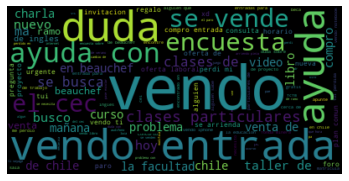

In [173]:
plotWordCloud(mergedTitles)

#### Yearly word clouds

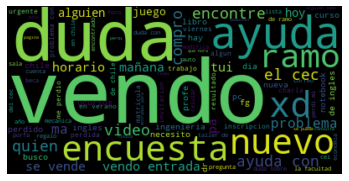

Year: 2009


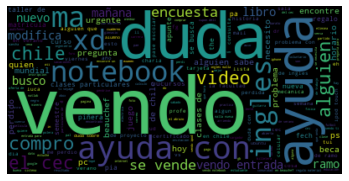

Year: 2010


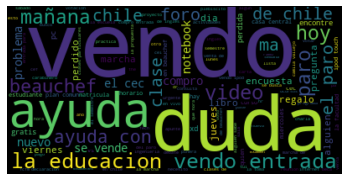

Year: 2011


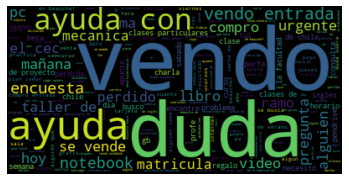

Year: 2012


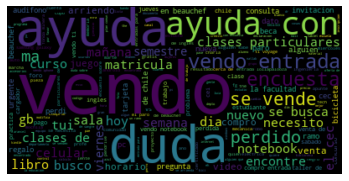

Year: 2013


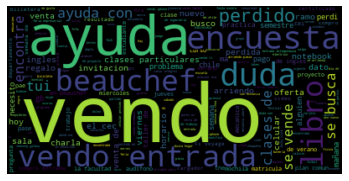

Year: 2014


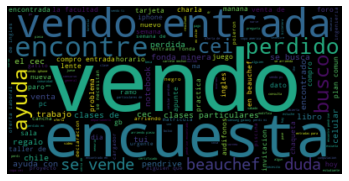

Year: 2015


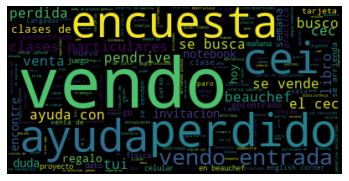

Year: 2016


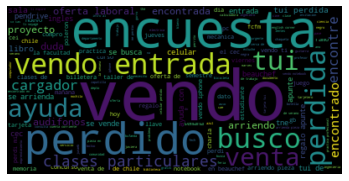

Year: 2017


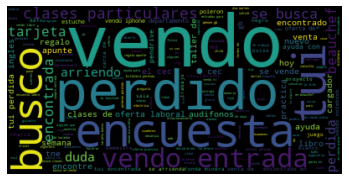

Year: 2018


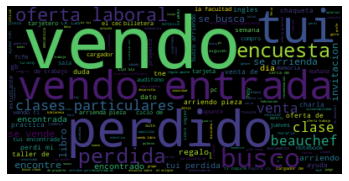

Year: 2019


In [174]:
for year in last_decade_titles_count.index:
    titles_from_year = forum_titles_frame[forum_titles_frame['date'] == year]
    mergedText = formatAndMergeStringsFromSeries(titles_from_year["title"])
    plotWordCloud(mergedText)
    print("Year: {}".format(year))

### Threads about mental health

#### init lemmatizer

In [175]:
resource_file = 'lemmatization-es.txt'
lemmatiser_es = lemmatiser(create_lemma_dict(resource_file))

In [191]:
mental_health_keywords = set(['ansiedad', 'desmotivación', 'estres', 'concentracion', 'deprimido', 'depresion',
                             'animo', 'psicologica', 'mental', 'siquiatra', 'psicologa', 'motiva', 'autocuidado'])
mental_health_lemmas = set(map(lemmatiser_es, mental_health_keywords))

#for year in last_decade_titles_count.index:
def lemmatizeSentence(sentence):
    return " ".join(map(lemmatiser_es, sentence.split(" ")))

def cleanAndLemmatizeTitles(titleSerie):
    return formatStrings(titleSerie).transform(lemmatizeSentence)

def isTopicOfInterest(sentenceSeries):
    return sentenceSeries.transform(lambda sentence: 1 if any(map(lambda word: word in mental_health_lemmas, sentence.split(" "))) else 0)

titles_mapped = forum_titles_frame[['title']].apply(cleanAndLemmatizeTitles).apply(isTopicOfInterest)
titles_mapped[['date']] = forum_titles_frame[['date']].reset_index(drop=True)
titles_mapped.head()

,title,date
0,0,2020
1,0,2020
2,0,2020
3,0,2020
4,0,2020


In [192]:
titles_mapped.groupby(['date']).sum()

,title
date,
2002,0
2003,0
2006,0
2007,0
2008,0
2009,13
2010,16
2011,11
2012,14


In [48]:
def formatStrings(strings):
    tildes = ['á','é','í','ó','ú']
    vocales = ['a','e','i','o','u']

    # tildes
    for idx, vocal in enumerate(vocales):
        strings = strings.str.replace(tildes[idx],vocal)

    # borrar caracteres especiales menos la ñ
    strings = strings.str.replace('[^a-zñA-Z ]', "")

    # todo a minusculas
    strings = pd.Series(list(map(lambda x: x.lower(), strings)))
    
    return strings

In [73]:
def obtainMergedStringsFromSeries(dataSeries):
    return " ".join(dataSeries)

In [72]:
def formatAndMergeStringsFromSeries(dataSeries):
    return obtainMergedStringsFromSeries(formatStrings(dataSeries))

In [81]:
def plotWordCloud(text):
    wordcloud = WordCloud(stopwords=stopwords_es).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [120]:
def lemmatiser(dict):
    def lookup(word):
        try:
            lemma = dict[word]
        except:
            lemma = word
        
        return lemma
    
    return lookup

In [121]:
def create_lemma_dict(filename):
   with open(filename, 'r') as document:
       lemma_dict = {}
       for line in document:
           if line.strip():  # avoid empty lines
               value, key = line.split(None, 1) # 'None' means 'all whitespace', which is the default
               key = key.rstrip() # rstrip() to get rid of \r and \n
               lemma_dict[key] = value # adding the flections as keys to the dict
               lemma_dict[value] = value # adding also the base word as a key
   return lemma_dict